# Tutorial: Building and using an ADS Network
Author: Julian Buechel

Date: July 1st, 2020

## Introduction
In this tutorial, we'll be looking at the ADS Network. ADS stands for <b>A</b>rbitrary <b>D</b>ynamical <b>S</b>ystems and is referring to the fact that this network is able to learn any non-linear dynamical system of the form

$$\dot{x} = f(x) + c$$

where $c$ is a continuous input and $f(.)$ some arbitrary non-linear function.

Being able to learn how to implement an arbitrary dynamical system in a spiking network is a powerful ability, which can be exploited to do more complex tasks, such as training a classifier for temporal tasks like wake-phrase detection or keyword spotting.

## Background
<b>E</b>fficient <b>B</b>alanced <b>N</b>etworks (<b>EBN</b>) [1](https://www.nature.com/articles/nn.4243) have coding properties that are of high interest to the neuromorphic community: They encode signals in an extremely precise and sparse way while still being robust to various types of noise.

This architecture is actually really easy as it doesn't require any training. In 2017, Alemi et al. [2](https://arxiv.org/abs/1705.08026) have demonstrated that a spiking network can be trained to follow the non-linear dynamics of a teacher system while still keeping tight balance and robustness to sudden neuron death.

We adapted their learning rule from adaptive non-linear control theory and stripped down their architecture to the bare minimum of complexity (we for example got rid of the dendritic non-linearities) in order to use it to our advantage.

## Technical details
With the goal in mind to train a classifier using this network architecture, we realised that a classic rate network with the following dynamics
$$\tau_j \dot{x}_j = -x_j + \hat{\mathbf{F}}c(t)_j + \hat{\mathbf{\Omega}}f(x(t))_j + b_j + \epsilon_j$$
actually implements a function of the form
$$\dot{x} = f(x) + c$$
which can be learned by the ADS Network!
This means that we can train a rate network using BPTT (backpropagation through time) and then train a spiking ADS Network to mimic the rate networks dynamics.

![Caption](images/learning_setup.png)

This image portraits the setup during learning for an audio task: The raw audio sample is filtered using a filterbank and then fed through the linear feed-forward matrix of the trained rate networks, here denoted $\hat{F}$. This signal is then fed into the rate network, where the rate network produces some dynamics $x$ in response to the input. Since the rate network is already trained, these dynamics exhibit a useful pattern that can be decoded using the, also trained, read-out weights $\hat{D}$, which are shown in the figure below.
Now comes the spiking ADS network with $N$ neurons, which is typically 6 times the number of rate units. The transformed signal $\hat{F}c$ is fed into the spiking network through another encoder $F$. The plastic weights $\mathbf{\Omega^s}$ are then trained so the the output $\hat{x} = Dr$ matches the dynamics of the rate network.
The great thing is that $D$ is fixed and pre-defined: It is simply the transpose of $F$.

![Caption](images/inference_setup.png)

During inference, the rate network does not matter anymore and we can feed the audio signal through the network using the feed-forward matrix $F\hat{F}$ and the decoder matrix $\hat{D}D$.

# Temporal XOR
We will now show how to train a rate network on a 1D temporal XOR task and then train an ADS network to implement the dynamics of this network.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import numpy as np
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['lines.markersize'] = 0.5
matplotlib.rcParams['figure.figsize'] = 15, 5
import matplotlib.pyplot as plt
from rockpool.layers import RecRateEulerJax_IO, H_tanh
from rockpool.networks import NetworkADS
from rockpool.timeseries import TSContinuous
from jax import jit
import jax.numpy as jnp
from typing import Dict, Tuple, Any, Callable, Union, List, Optional
import os
import json

In [2]:
# Create some helper functions
# Moving average for smoothing the response
def filter_1d(data, alpha = 0.9):
    last = data[0]
    out = np.zeros((len(data),))
    out[0] = last
    for i in range(1,len(data)):
        out[i] = alpha*out[i-1] + (1-alpha)*data[i]
        last = data[i]
    return out

def generate_xor_sample(total_duration, dt, amplitude=1, use_smooth=True, plot=False):
    """
    Generates a temporal XOR signal
    """
    input_duration = 2/3*total_duration
    # Create a time base
    t = np.linspace(0,total_duration, int(total_duration/dt)+1)
    first_duration = np.random.uniform(low=input_duration/10, high=input_duration/4 )
    second_duration = np.random.uniform(low=input_duration/10, high=input_duration/4 )
    end_first = np.random.uniform(low=first_duration, high=2/3*input_duration-second_duration)
    start_first = end_first - first_duration
    start_second = np.random.uniform(low=end_first + 0.1, high=2/3*input_duration-second_duration) # At least 200 ms break
    end_second = start_second+second_duration
    data = np.zeros(int(total_duration/dt)+1)
    i1 = np.random.rand() > 0.5
    i2 = np.random.rand() > 0.5
    response = (((not i1) and i2) or (i1 and (not i2)))
    if(i1):
        a1 = 1
    else:
        a1 = -1
    if(i2):
        a2 = 1
    else:
        a2 = -1
    input_label = 0
    if(a1==1 and a2==1):
        input_label = 0
    elif(a1==1 and a2==-1):
        input_label = 1
    elif(a1==-1 and a2==1):
        input_label = 2
    else:
        input_label = 3
    data[(start_first <= t) & (t < end_first)] = a1
    data[(start_second <= t) & (t < end_second)] = a2
    if(use_smooth):
        sigma = 10
        w = (1/(sigma*np.sqrt(2*np.pi)))* np.exp(-((np.linspace(1,1000,int(1/dt))-500)**2)/(2*sigma**2))
        w = w / np.sum(w)
        data = amplitude*np.convolve(data, w, "same")
    else:
        data *= amplitude
    target = np.zeros(int(total_duration/dt)+1)
    if(response):
        ar = 1.0
    else:
        ar = -1.0
    target[int(1/dt*(end_second+0.05)):int(1/dt*(end_second))+int(1/dt*0.3)] = ar
    sigma = 20
    w = (1/(sigma*np.sqrt(2*np.pi)))* np.exp(-((np.linspace(1,1000,int(1/dt))-500)**2)/(2*sigma**2))
    w = w / np.sum(w)
    target = np.convolve(target, w, "same")
    target /= np.max(np.abs(target))
    if(plot):
        eps = 0.05
        plt.subplot(211)
        plt.plot(t, data)
        plt.ylim([-amplitude-eps, amplitude+eps])
        plt.subplot(212)
        plt.plot(t, target)
        plt.show()
    return (data[:int(total_duration/dt)], target[:int(total_duration/dt)], input_label)

def k_step_function(total_num_iter, step_size, start_k):
    stop_k = step_size
    num_reductions = int((start_k - stop_k) / step_size) + 1
    reduce_after = int(total_num_iter / num_reductions)
    reduction_indices = [i for i in range(1,total_num_iter) if (i % reduce_after) == 0]
    k_of_t = np.zeros(total_num_iter)
    if(total_num_iter > 0):
        k_of_t[0] = start_k
        for t in range(1,total_num_iter):
            if(t in reduction_indices):
                k_of_t[t] = k_of_t[t-1]-step_size
            else:
                k_of_t[t] = k_of_t[t-1]

    return k_of_t


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


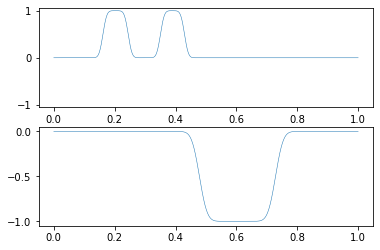

In [3]:
# Quick demonstration of the input data
_,_,_ = generate_xor_sample(total_duration=1.0, dt=0.001, plot=True)

In [4]:
# - Initialize some variables
# - Define global parameters
verbose = 1 # - Level of verbosity also for the ADS Network (use 1 for this tutorial)
activation_func = H_tanh # - Should be kept to tanh
duration = 1.0 # - Duration of the signal in seconds
dt = 1e-3 # - Simulation time step in seconds
amplitude = 1.0
num_units = 64 # - Corresponds to the number of neurons in the rate network
noise_std = 0.0
num_epochs = 100
num_batches = 100
num_channels = 1 # - Number of input channels. Here 1 for the 1D input
num_targets = 1 # - Output dimension is also 1D
time_base = np.arange(0,duration,dt)

# - Create the rate network
w_in = 10.0 * (np.random.rand(num_channels, num_units) - .5)
w_rec = 0.2 * (np.random.rand(num_units, num_units) - .5)
w_rec -= np.eye(num_units) * w_rec

w_out = 0.4*np.random.uniform(size=(num_units, num_targets))-0.2
bias = 0.0 * (np.random.rand(num_units) - 0.5)
tau = np.linspace(0.01, 0.1, num_units)

sr = np.max(np.abs(np.linalg.eigvals(w_rec)))
w_rec = w_rec / sr * 0.95

In [5]:
if(not os.path.exists("./Resources")):
    print("Creating Resources folder"); os.mkdir("./Resources")

model_path = "./Resources/temporal_xor_rate_model_64.json"
loaded_pretrained = False
if(os.path.exists(model_path)):
    with open(model_path, 'rb') as f:
        loaded_net = json.load(f)
        if(loaded_net['activation_func'] == 'tanh'):
            activation_func = H_tanh
        else:
            assert(False), "Please use tanh"
        lyr_hidden = RecRateEulerJax_IO(activation_func=activation_func,
                                        w_in=loaded_net['w_in'],
                                        w_recurrent=loaded_net['w_recurrent'],
                                        w_out=loaded_net['w_out'],
                                        tau=loaded_net['tau'],
                                        bias=loaded_net['bias'],
                                        dt=loaded_net['dt'],
                                        noise_std=loaded_net['noise_std'],
                                        name="hidden")
        loaded_pretrained = True
        w_out = loaded_net['w_out']
        print("Loaded pretrained layer")

else:
    # - Create the rate layer
    lyr_hidden = RecRateEulerJax_IO(activation_func=activation_func,
                                                w_in=w_in,
                                                w_recurrent=w_rec,
                                                w_out=w_out,
                                                tau=tau,
                                                bias=bias,
                                                dt=dt,
                                                noise_std=noise_std,
                                                name="hidden")

Loaded pretrained layer


In [6]:
if(not loaded_pretrained):
    # - Start training
    for epoch in range(num_epochs):
        num_samples = 0
        mvg_avg_mse = 0

        for batch_id in range(num_batches):

            # - Generate new training data
            data, target, _ = generate_xor_sample(total_duration=duration, dt=dt, amplitude=amplitude)
            ts_data = TSContinuous(time_base, data)
            ts_target = TSContinuous(time_base, target)

            lyr_hidden.reset_time()
            l_fcn, g_fcn, o_fcn = lyr_hidden.train_output_target(ts_data,
                                                                    ts_target,
                                                                    is_first = (batch_id == 0) and (epoch == 0),
                                                                    opt_params={"step_size": 1e-4})

            ts_out = lyr_hidden.evolve(ts_data)

            if(verbose > 0):
                clear_output(wait=True)
                plt.clf()
                ts_target.plot(linestyle='--')
                ts_out.plot()
                plt.draw()
                plt.pause(0.0001)

            mse = np.linalg.norm(ts_target.samples-ts_out.samples)**2
            mvg_avg_mse = mvg_avg_mse * num_samples + mse
            num_samples += 1
            mvg_avg_mse /= num_samples

            print(f"Moving average is {mvg_avg_mse} tau max {np.max(lyr_hidden.tau)} mean {np.mean(lyr_hidden.tau)}")
            print(f"bias max {np.max(lyr_hidden.bias)} mean {np.mean(lyr_hidden.bias)}")
    lyr_hidden.reset_all()
    lyr_hidden.noise_std = 0.0
    
    # - Save rate net
    lyr_hidden.save_layer(model_path)
    print("Saved layer")
else:
    print("No training, pretrained layer was loaded")

No training, pretrained layer was loaded


In [7]:
# - Define parameters used by the ADS Network

Nc = num_units
num_neurons = 768 # - This can be varied

dt = 0.001
duration = 1.0
time_base = np.arange(0,duration,dt)
lambda_d = 20
lambda_v = 20
tau_mem = 1/ lambda_v

tau_slow = 0.07 # 70ms
tau_out = 0.07

# - See Boerlin, Machens and Deneve for the calculations below
tau_syn_fast = tau_slow
mu = 0.0005
nu = 0.0001
D = np.random.randn(Nc,num_neurons) / Nc
weights_fast = (D.T@D + mu*lambda_d**2*np.eye(num_neurons))
# - Start with zero weights 
weights_slow = np.zeros((num_neurons,num_neurons))

eta = 0.0001
k = 100
# - Pull out thresholds
v_thresh = (nu * lambda_d + mu * lambda_d**2 + np.sum(abs(D.T), -1, keepdims = True)**2) / 2
# - Fill the diagonal with zeros
np.fill_diagonal(weights_fast, 0)

# - Calculate weight matrices for realistic neuron settings
v_thresh_target = 1.0*np.ones((num_neurons,)) # - V_thresh
v_rest_target = 0.5*np.ones((num_neurons,)) # - V_rest = b

b = v_rest_target
a = v_thresh_target - b

# - Feedforward weights: Divide each column i by the i-th threshold value and multiply by i-th value of a
D_realistic = a*np.divide(D, v_thresh.ravel())
weights_in_realistic = D_realistic
weights_out_realistic = np.copy(D_realistic).T
weights_fast_realistic = a*np.divide(weights_fast.T, v_thresh.ravel()).T # - Divide each row

# - Reset is given by v_reset_target = b - a
v_reset_target = b - a
noise_std_realistic = 0.00

# - Initialize network
# - Use discretize_dynapse=True if the DYNAP-SE II constraints should be used
net = NetworkADS.SpecifyNetwork(N=num_neurons,
                                Nc=Nc,
                                Nb=num_neurons,
                                weights_in= weights_in_realistic * tau_mem,
                                weights_out= weights_out_realistic,
                                weights_fast= - weights_fast_realistic / tau_syn_fast * 0, # - We will not use the fast recurrent connections here
                                weights_slow = weights_slow,
                                eta=eta,
                                k=k,
                                noise_std=noise_std_realistic,
                                dt=dt,
                                v_thresh=v_thresh_target,
                                v_reset=v_reset_target,
                                v_rest=v_rest_target,
                                tau_mem=tau_mem,
                                tau_syn_r_fast=tau_syn_fast,
                                tau_syn_r_slow=tau_slow,
                                tau_syn_r_out=tau_out,
                                record=True)

amplitude = 10 / tau_mem

## Helper function
This helper function passes the temporal-XOR input through the rate network and returns:

- The transformed input $\hat{F}c$ that gets fed into the spiking network
- The rate network dynamics $x$ that the spiking network needs to generate
- And the output of the rate network for plotting and error calculation

In [8]:
def get_data(data):
        ts_data = TSContinuous(time_base, data)
        # - Pass through the rate network
        ts_rate_out = lyr_hidden.evolve(ts_data)
        lyr_hidden.reset_all()
        # - Get the target dynamics
        ts_rate_net_target_dynamics = lyr_hidden.res_acts_last_evolution
        # - Get the input into the spiking network
        ts_spiking_in = TSContinuous(lyr_hidden.res_inputs_last_evolution.times,amplitude*lyr_hidden.res_inputs_last_evolution.samples)
        return (ts_spiking_in, ts_rate_net_target_dynamics, ts_rate_out)

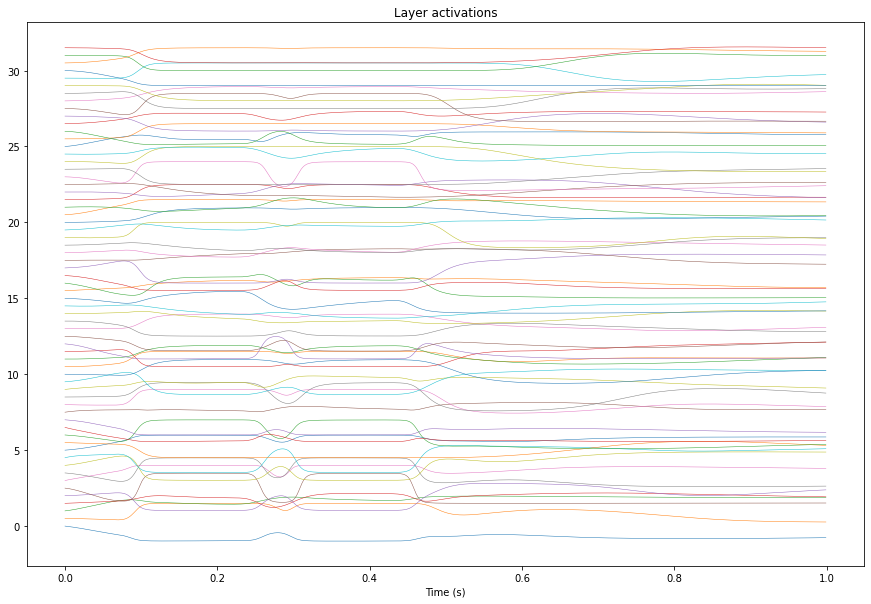

In [9]:
# - Test the function

ts_test_spiking_in, ts_test_rate_dynamics, ts_test_rate_out = get_data(data=generate_xor_sample(total_duration=duration, dt=dt)[0])
plt.figure(figsize=(15,10)); ts_test_rate_dynamics.plot(stagger=0.5); plt.show()

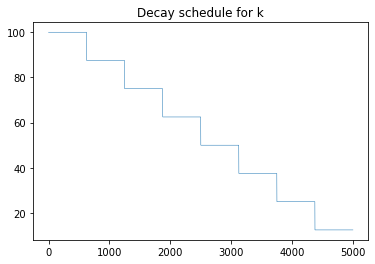

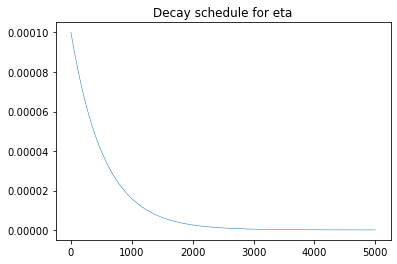

In [10]:
# - Create schedules for eta and k

num_epochs = 5
num_samples_per_epoch = 1000 # TODO Change that to 500-1000

# - Create step schedule for k
step_size = net.lyrRes.k_initial / 8
total_num_iter = num_epochs*num_samples_per_epoch
k_of_t = k_step_function(total_num_iter=total_num_iter,
                            step_size=step_size,
                            start_k = net.lyrRes.k_initial)
if(total_num_iter > 0):
    f_k = lambda t : np.maximum(step_size,k_of_t[t])
    if(verbose > 0):
        plt.plot(np.arange(0,total_num_iter),f_k(np.arange(0,total_num_iter))); plt.title("Decay schedule for k"); plt.show()
else:
    f_k = lambda t : 0
    
# - Create schedule for eta
a_eta = net.lyrRes.eta_initial
b_eta = (total_num_iter/2) / np.log(100)
c_eta = 0.0000001
f_eta = lambda t,a_eta,b_eta : a_eta*np.exp(-t/b_eta) + c_eta

if(verbose > 0):
    plt.plot(np.arange(0,total_num_iter),f_eta(np.arange(0,total_num_iter),a_eta,b_eta))
    plt.title("Decay schedule for eta"); plt.show()

## Notes about training
There are a few things to keep in mind when training an ADS Network:

- During training, an error-dependent current $kD^Te$ is fed into the neurons. This current steers they dynamics into the correct direction so that they follow the target dynamics. This will lead to a small reconstruction error during training, but does not mean that the reconstruction error is low during validation (when the current is suddently gone).
- The hyperparameter $k$ should be chosen in a way that the magnitudes of error- and output current match. As stated before, a too big error current will lead to no generalization
- Scale of the output weights: This is a hyperparameter that turned out important. For smooth target dynamics a scale < 1 (e.g. 0.5) is good and for more sharp and abrupt dynamics a scalar >= 1 is good (like in this tutorial).

In [ ]:
# - Do the training of the ADS Network
%matplotlib qt

np.random.seed(42)
time_horizon = 50
recon_errors = np.ones((time_horizon,))
avg_training_acc = np.zeros((time_horizon,)); avg_training_acc[:int(time_horizon/2)] = 1.0
was_first = False


def validate():
    # - Evolve over new examples without learning
    for _ in range(10):
        data, target, _ = generate_xor_sample(total_duration=duration, dt=dt, amplitude=1.0)
        (ts_spiking_in, _, ts_rate_out) = get_data(data=data)
        test_sim = net.evolve(ts_input = ts_spiking_in, verbose = False)
        out_val = test_sim["output_layer_0"].samples
        final_out = out_val @ lyr_hidden.w_out
        final_out = filter_1d(final_out, alpha=0.95)
        clear_output(wait=True)
        plt.clf()
        plt.plot(time_base, final_out, label="Spiking")
        plt.plot(time_base, target, label="Target")
        plt.plot(time_base, ts_rate_out.samples, label="Rate")
        plt.axhline(y=0.5, color="r")
        plt.axhline(y=-0.5, color="r")
        plt.ylim([-1.5,1.5])
        plt.legend()
        plt.draw()
        plt.pause(0.5)
        net.reset_all()

for epoch in range(num_epochs):
    
    validate()
    
    for batch_id in range(num_samples_per_epoch):
        
        # - Get data
        data, target, _ = generate_xor_sample(total_duration=duration, dt=dt, amplitude=1.0)
        (ts_spiking_in, ts_rate_net_target_dynamics, ts_rate_out) = get_data(data=data)
        
        train_sim = net.train_step(ts_input = ts_spiking_in,
                                   ts_target = ts_rate_net_target_dynamics,
                                   k = f_k(epoch*num_samples_per_epoch+batch_id),
                                   eta = f_eta(epoch*num_samples_per_epoch+batch_id, a_eta, b_eta),
                                   verbose = False)

        # - Compute train loss & update the moving averages
        out_val = train_sim["output_layer_0"].samples
        target_val = ts_rate_net_target_dynamics.samples
        error = np.sum(np.var(target_val-out_val, axis=0, ddof=1)) / (np.sum(np.var(target_val, axis=0, ddof=1)))
        recon_errors[1:] = recon_errors[:-1]
        recon_errors[0] = error
        # - Initialize the error array with the first reconstruction error we get
        if(not was_first):
            was_first = True
            recon_errors = [error for _ in range(time_horizon)]

        # - Compute the final output using the reconstructed dynamics and the trained read-out of the rate net
        final_out = out_val @ lyr_hidden.w_out
        # - ..and filter
        final_out = filter_1d(final_out, alpha=0.95)

        # - Some plotting
        if(verbose > 0):
            clear_output(wait=True)
            plt.clf()
            plt.plot(time_base, final_out, label="Spiking")
            plt.plot(time_base, target, label="Target")
            plt.plot(time_base, ts_rate_out.samples, label="Rate")
            plt.ylim([-1.5,1.5])
            plt.legend()
            plt.draw()
            plt.pause(0.001)
        
        print(("Avg. reconstruction error %.4f" % (np.mean(recon_errors))), "K", net.lyrRes.k, "Epoch", epoch, "Batch", batch_id)
net.reset_all()
        

Avg. reconstruction error 0.1214 K 75.0 Epoch 1 Batch 313


In [ ]:
validate()